In [1]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)  # To check whether CUDA is being used


cpu


In [2]:
pip install roboflow



  Using cached idna-3.7-py3-none-any.whl.metadata (9.9 kB)
  Using cached opencv_python_headless-4.10.0.84-cp37-abi3-win_amd64.whl.metadata (20 kB)
Using cached idna-3.7-py3-none-any.whl (66 kB)
Using cached opencv_python_headless-4.10.0.84-cp37-abi3-win_amd64.whl (38.8 MB)
   ---------------------------------------- 0.0/8.6 MB ? eta -:--:--
   --- ------------------------------------ 0.8/8.6 MB 8.3 MB/s eta 0:00:01
   -------- ------------------------------- 1.8/8.6 MB 4.6 MB/s eta 0:00:02
   ------------ --------------------------- 2.6/8.6 MB 4.3 MB/s eta 0:00:02
   --------------- ------------------------ 3.4/8.6 MB 4.1 MB/s eta 0:00:02
   ------------------- -------------------- 4.2/8.6 MB 4.1 MB/s eta 0:00:02
   ----------------------- ---------------- 5.0/8.6 MB 4.0 MB/s eta 0:00:01
   ---------------------------- ----------- 6.0/8.6 MB 4.0 MB/s eta 0:00:01
   ------------------------------- -------- 6.8/8.6 MB 4.0 MB/s eta 0:00:01
   ----------------------------------- ---- 7.6

In [3]:
from roboflow import Roboflow
rf = Roboflow(api_key="2kcAEbVttDMc0KjCLUu9")  # Get from Roboflow settings
project = rf.workspace("cg2").project("cg2")
dataset = project.version(6).download("coco")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to cg2-6 in coco:: 100%|██████████| 22757/22757 [00:48<00:00, 472.58it/s]


In [4]:
# Step 3: Import libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tensorflow.keras import backend as K
from tensorflow.keras.applications import vgg19

In [5]:
def load_and_preprocess(image_path, img_size=(512, 512)):  # Increased resolution to 512x512
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Could not read image at {image_path}")
        
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, img_size)
    img = img.astype('float32') / 255.0
    
    # Explicit CPU placement for preprocessing
    with tf.device('/CPU:0'):
        tensor_img = tf.convert_to_tensor(img[np.newaxis, ...], dtype=tf.float32)
        
    return tensor_img


In [6]:
import os
import random
from tqdm import tqdm 

dataset_path = "C:/Users/perei/Downloads/cg2-6/train"  # Path to COCO dataset

content_images = []
image_files = [f for f in os.listdir(dataset_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

random.shuffle(image_files)
image_files = image_files[:1]  # Select one content image for testing

for img_file in tqdm(image_files, desc="Loading content images", unit="img"):
    try:
        img_path = os.path.join(dataset_path, img_file)
        content_images.append(load_and_preprocess(img_path))
        print(f"Successfully loaded: {img_path}")
    except Exception as e:
        print(f"Error loading {img_file}: {str(e)}")


Loading content images: 100%|██████████| 1/1 [00:00<00:00,  8.45img/s]

Successfully loaded: C:/Users/perei/Downloads/cg2-6/train\0_10-17-10-10-11-5160711695692955025022903805502_jpg.rf.8a0d991c5b4452fb559ddbb45ac3a39f.jpg


In [8]:
style_image_folder = "C:/Users/perei/Downloads/style_images"  # Update path to your style images folder

style_images = os.listdir(style_image_folder)

if style_images:
    style_image_path = os.path.join(style_image_folder, style_images[0])  # Use the first style image
    style_image = load_and_preprocess(style_image_path, (512, 512))  # Match resolution with content image
else:
    raise ValueError("No style images found in the specified folder.")


In [9]:
def get_model():
    vgg = vgg19.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    
    # Select layers for content and style representation
    content_layers = ['block5_conv2']  # Content layer for high-level features
    style_layers = ['block1_conv1', 'block3_conv1', 'block5_conv1']  # Fewer layers for better blending
    
    outputs = [vgg.get_layer(name).output for name in (style_layers + content_layers)]
    model = tf.keras.Model(vgg.input, outputs)
    
    return model, style_layers

model, style_layers = get_model()


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 22s 0us/step


In [10]:
def content_loss(base, target):
    return tf.reduce_mean(tf.square(base - target)) + 1e-8

def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result / (num_locations + 1e-8)

def style_loss(base, gram_target):
    gram_style = gram_matrix(base)
    return tf.reduce_mean(tf.square(gram_style - gram_target))

content_weight = 1e3  # Increased weight for content preservation
style_weight = 1e4   # Reduced weight for style influence


In [11]:
def compute_loss(combined_image, content_targets, style_targets):
    model_outputs = model(combined_image)
    content_outputs = model_outputs[len(style_layers):]
    style_outputs = model_outputs[:len(style_layers)]
    
    c_loss = tf.add_n([content_loss(content_output, content_target) 
                      for content_output, content_target in zip(content_outputs, content_targets)])
    
    s_loss = tf.add_n([style_loss(style_output, style_target) 
                      for style_output, style_target in zip(style_outputs, style_targets)])
    
    return content_weight * c_loss + style_weight * s_loss


In [12]:
def train_step(image, content_targets, style_targets, opt):
    with tf.GradientTape() as tape:
        loss = compute_loss(image, content_targets, style_targets)
    
    grad = tape.gradient(loss, image)
    grad_clipped = tf.clip_by_value(grad, -0.5, 0.5)  # Adjusted clipping range for stability
    
    opt.apply_gradients([(grad_clipped, image)])  # Use the optimizer passed as an argument
    
    return loss


def style_transfer(content_image, style_image, epochs=200):  
    with tf.device('/CPU:0'):
        content_targets = model(content_image)[len(style_layers):]
        style_targets = [gram_matrix(style_layer) for style_layer in model(style_image)[:len(style_layers)]]

        generated_image = tf.Variable(content_image)  # Make sure it's a variable
        opt = tf.optimizers.Adam(learning_rate=0.01)  # Recreate optimizer inside function
        
        best_loss = float('inf')
        best_image = None

        for epoch in range(epochs):
            loss = train_step(generated_image, content_targets, style_targets, opt)  # Pass optimizer
            
            if loss < best_loss:
                best_loss = loss
                best_image = generated_image.numpy().copy()

            if epoch % 25 == 0:
                print(f"Epoch {epoch}, Loss: {loss.numpy():.2f}")

        return best_image[0]



In [13]:
opt = tf.optimizers.Adam(learning_rate=0.01)  # Initialize optimizer


Starting style transfer...
Epoch 0, Loss: 252394.92
Epoch 25, Loss: 5399.32
Epoch 50, Loss: 1662.02
Epoch 75, Loss: 1207.62
Epoch 100, Loss: 1058.52
Epoch 125, Loss: 980.24
Epoch 150, Loss: 929.03
Epoch 175, Loss: 892.11
Style transfer complete!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.49764022..1.5560958].


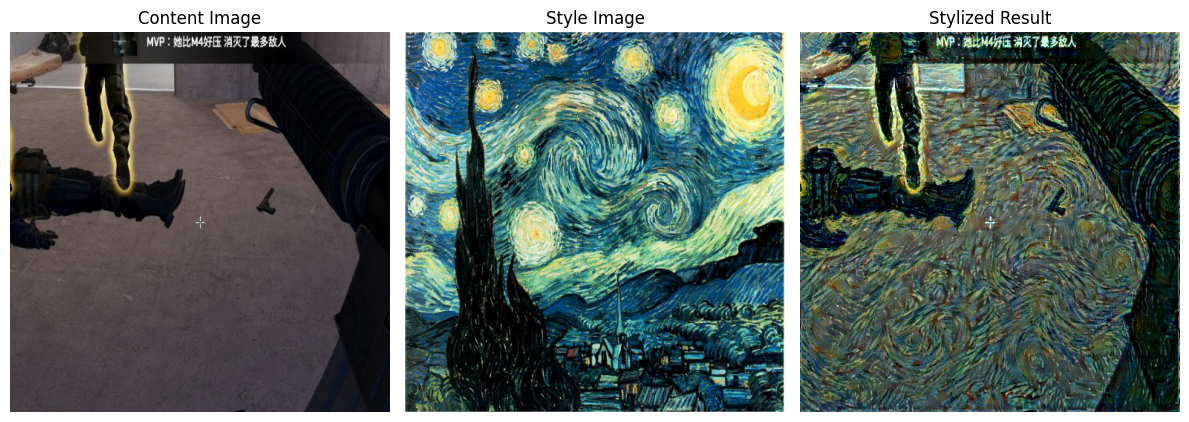

In [14]:
try:
    if content_images:
        content_image = content_images[0]
        
        print("Starting style transfer...")
        stylized_image_result = style_transfer(content_image, style_image)
        print("Style transfer complete!")
        
        plt.figure(figsize=(12, 6))
        
        plt.subplot(1, 3, 1)
        plt.title("Content Image")
        plt.imshow(content_image[0])
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.title("Style Image")
        plt.imshow(style_image[0])
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.title("Stylized Result")
        plt.imshow(stylized_image_result)
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
except Exception as e:
    print(f"Error during execution: {str(e)}")


In [18]:
import os

style_image_folder = "C:/Users/perei/Downloads/style_images" # Path to style images folder

# List all image files (JPG, PNG, JPEG)
style_images = [f for f in os.listdir(style_image_folder) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

# Print all available style image names
print("Available style images:")
for img in style_images:
    print(img)


Available style images:
starry_night.jpg


Using style image: VanGogh_StarryNight01m.jpg
Starting style transfer...
Epoch 0, Loss: 267697.66
Epoch 25, Loss: 6045.46
Epoch 50, Loss: 1985.29
Epoch 75, Loss: 1437.76
Epoch 100, Loss: 1249.20
Epoch 125, Loss: 1147.18
Epoch 150, Loss: 1078.36
Epoch 175, Loss: 1026.19
Style transfer complete! Time taken: 1848.38 seconds


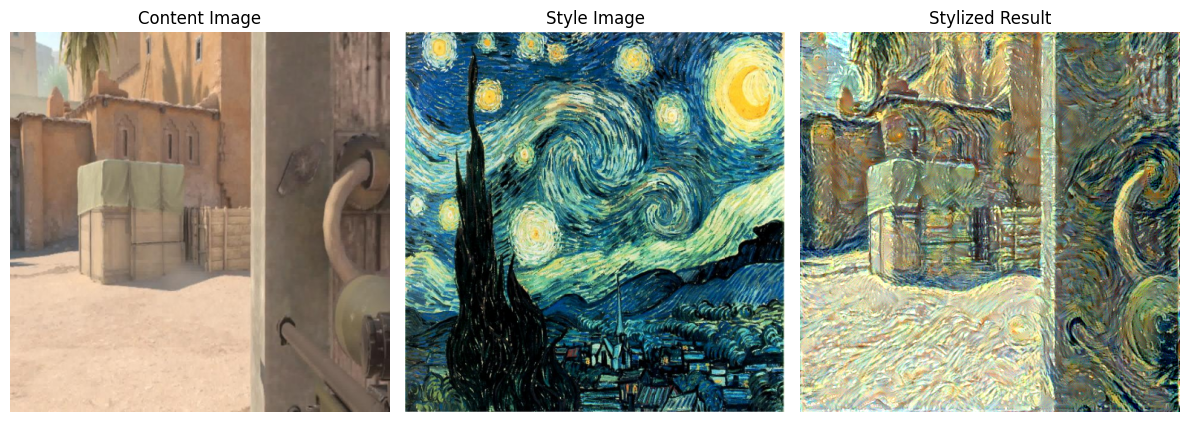

In [ ]:
import time
import os
import matplotlib.pyplot as plt

# Set the desired style image
style_image_name = "starry_night.jpg"  # Change this to your desired style image filename

style_image_path = os.path.join(style_image_folder, style_image_name)

if os.path.exists(style_image_path):
    style_image = load_and_preprocess(style_image_path, (512, 512))  # Match resolution with content image
    print(f"Using style image: {style_image_name}")
else:
    raise ValueError(f"Style image '{style_image_name}' not found in the folder.")

try:
    if content_images:
        content_image = content_images[0]

        print("Starting style transfer...")
        
        # Start the timer
        start_time = time.time()
        
        # Run style transfer
        stylized_image_result = style_transfer(content_image, style_image, epochs=200)
        
        # End the timer
        end_time = time.time()
        
        print(f"Style transfer complete! Time taken: {end_time - start_time:.2f} seconds")

        # Display final results
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 3, 1)
        plt.title("Content Image")
        plt.imshow(content_image[0])
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.title("Style Image")
        plt.imshow(style_image[0])
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.title("Stylized Result")
        plt.imshow(stylized_image_result)
        plt.axis('off')

        plt.tight_layout()
        plt.show()

except Exception as e:
    print(f"Error during execution: {str(e)}")
